## DASC 550 Project3: Electricity Demand Prediction
### Burak Albayrak
### 0078324

#### Submission Deadline: August 29, 2022 11:59 PM

In this project, you are going to build an end-to-end machine learning solution using a recurrent neural network for electricity demand prediction problem. You should use `tensorflow` library to build your neural network.

The data set is provided at  https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption, which contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). The measurements are given at the minute resolution. You should first resample data to obtain hourly measurements using `pandas.DataFrame.resample` function. The target variable is at `global_active_power` column. You will predict the electricity demand of the next hour using past measurements.

While building your regression model, you should decide what to do with missing values and how to split the data set into learning, validation and test sets. You should report the predictive performances on learning, validation and test sets.

You should also report the metrics you choose to measure the performance of the solution you developed and the reasoning behind your choices.

##### Selecting Features

* Since our data has numeric columns with different ranges, scaled all columns with the min max scaling. While doing this I was careful to do fitting and transforming on training data and this transformation applied to test data 

##### Metrics and Evaluating Model
* First I resampled data to hourly shape and took mean of the each hours
* Filled na(?) values with forward filling
* I constructed RNN model with LSTM with 256 units and dropout layers
* Since our problem is regression, I put linear activation to output node
* For additional features, I created new columns with day and month numbers 
* For metrics I only used sqrt mse for this model
* Since using all data has no big contribution for our model and for visualizing it is not helping, I used only the first 10 months of 2010 as train and 11th month as test
*                 Training sqmse: 0.49 
*                 Test sqmse: 0.53

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
data = pd.read_csv("household_power_consumption\household_power_consumption.txt", 
delimiter=';',
low_memory=False,
parse_dates={'dt' : ['Date', 'Time']}, 
infer_datetime_format=True,
index_col='dt',
na_values=['?']
)

In [3]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [4]:
data=data.fillna(method="ffill")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [6]:
data=data.resample('H').mean()


In [7]:
data.isna().any()

Global_active_power      False
Global_reactive_power    False
Voltage                  False
Global_intensity         False
Sub_metering_1           False
Sub_metering_2           False
Sub_metering_3           False
dtype: bool

In [8]:
data.loc['2010-01-01 00:00:00']

Global_active_power        1.085867
Global_reactive_power      0.084167
Voltage                  241.300000
Global_intensity           4.476667
Sub_metering_1             0.000000
Sub_metering_2             0.000000
Sub_metering_3             8.516667
Name: 2010-01-01 00:00:00, dtype: float64

In [9]:
display(data.head())
display(data.tail())

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000
2010-11-26 20:00:00,1.163700,0.061167,239.396000,4.913333,0.0,1.066667,0.000000
2010-11-26 21:00:00,0.934667,0.000000,239.690000,3.800000,0.0,0.000000,0.000000


In [21]:
X_train = data.loc["2010-01-01 00:00:00":"2010-10-31 23:00:00"].fillna(method = "ffill").to_numpy()
X_test = data.loc["2010-11-01 00:00:00":].fillna(method = "ffill").to_numpy()

y_train = data["Global_active_power"].loc["2010-01-01 00:00:00":"2010-10-31 23:00:00"].to_numpy()
y_test = data["Global_active_power"].loc["2010-11-01 00:00:00":].to_numpy()

y_train = y_train[:, None]
y_test = y_test[:, None]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(7296, 7) (622, 7)
(7296, 1) (622, 1)


In [22]:
scaler_X = MinMaxScaler(feature_range = (0.05, 0.95))
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler(feature_range = (0.05, 0.95))
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [23]:
print(len(data["2010-01-01 00:00:00":"2010-10-31 23:00:00"].index.day.to_numpy()))
print(len(data["2010-11-01 00:00:00":].index.day.to_numpy()))

7296
622


In [24]:
days = data["2010-01-01 00:00:00":"2010-10-31 23:00:00"].index.day.to_numpy()
days = days[:,None] / 31
months = data["2010-01-01 00:00:00":"2010-10-31 23:00:00"].index.month.to_numpy()
months = months[:,None] / 12
X_train = np.hstack((X_train, days, months))

days = data["2010-11-01 00:00:00":].index.day.to_numpy()
days = days[:,None] / 31
months = data["2010-11-01 00:00:00":].index.month.to_numpy()
months = months[:,None] / 12
X_test = np.hstack((X_test, days, months))

print(X_train.shape)
print(X_test.shape)

(7296, 9)
(622, 9)


In [25]:
window_size = 30
generator_train = TimeseriesGenerator(X_train,
                                      y_train,
                                      length = window_size,
                                      batch_size = 8)
generator_test = TimeseriesGenerator(X_test,
                                     y_test,
                                     length = window_size,
                                     batch_size = 1)

In [26]:
rnn_model = keras.models.Sequential([
    keras.layers.LSTM(units = 256, input_shape = (window_size, X_train.shape[1])),
    keras.layers.Dense(units = 128, activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 16, activation = "relu"),
    keras.layers.Dense(units = 1)
])

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               272384    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 307,361
Trainable params: 307,361
Non-trainable params: 0
_________________________________________________________________


In [16]:
rnn_model.compile(optimizer = "adam",
                  loss = "mean_squared_error")

In [17]:
rnn_history = rnn_model.fit(generator_train,
                            steps_per_epoch = len(generator_train),
                            epochs = 10)

Epoch 1/10
909/909 [==============================] - 24s 24ms/step - loss: 0.0122
Epoch 2/10
909/909 [==============================] - 22s 24ms/step - loss: 0.0092
Epoch 3/10
909/909 [==============================] - 22s 24ms/step - loss: 0.0087
Epoch 4/10
909/909 [==============================] - 22s 24ms/step - loss: 0.0084
Epoch 5/10
909/909 [==============================] - 21s 23ms/step - loss: 0.0082
Epoch 6/10
909/909 [==============================] - 20s 22ms/step - loss: 0.0081
Epoch 7/10
909/909 [==============================] - 20s 22ms/step - loss: 0.0079
Epoch 8/10
909/909 [==============================] - 20s 22ms/step - loss: 0.0077
Epoch 9/10
909/909 [==============================] - 21s 23ms/step - loss: 0.0077
Epoch 10/10
909/909 [==============================] - 20s 22ms/step - loss: 0.0076


In [18]:
y_train_hat = rnn_model.predict(generator_train)
y_test_hat = rnn_model.predict(generator_test)

y_train_original = scaler_y.inverse_transform(y_train)[:,0]
y_test_original = scaler_y.inverse_transform(y_test)[:,0]
print(y_train_original)

y_train_hat_scaled = scaler_y.inverse_transform(y_train_hat)[:,0]
y_test_hat_scaled = scaler_y.inverse_transform(y_test_hat)[:,0]
print(y_train_hat_scaled)

print(np.sqrt(mean_squared_error(y_train_original[window_size:], y_train_hat_scaled)))
print(np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_scaled)))

592/592 [==============================] - 2s 3ms/step
[1.08586667 0.65123333 0.6346     ... 1.21716667 1.32726667 2.038     ]
[0.721523   0.64724994 0.6991897  ... 0.69114494 1.6907749  1.6391618 ]
0.49831298168403754
0.5369384076945682


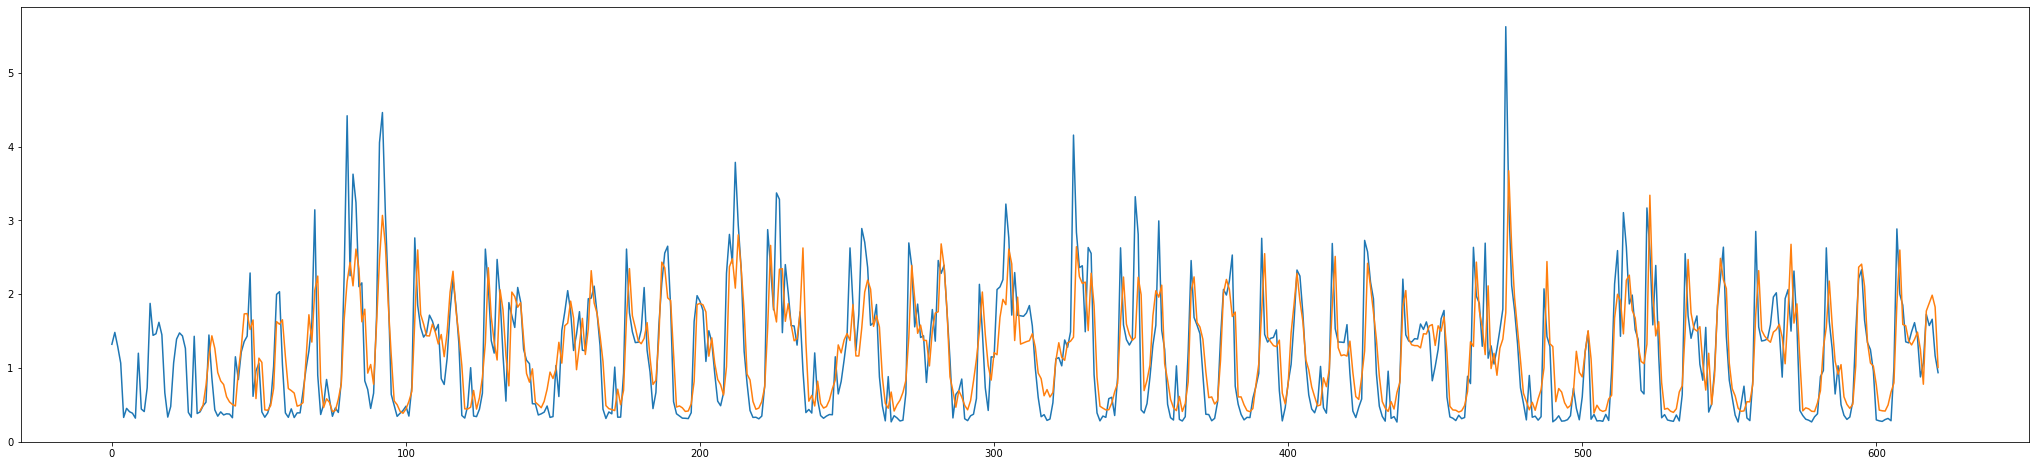

In [19]:
plt.figure(figsize = (36, 8))
plt.plot(range(len(y_test_original)), y_test_original)
plt.plot(np.arange(window_size, len(y_test_original)), y_test_hat_scaled)
plt.show()

In [ ]:
print('hi')